In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy # To copy objects

# --- Imports for Portfolio Optimization (Part 2) ---
import itertools # To create combinations
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting 

import riskfolio as rf
import ta
import scipy
print(scipy.__version__)

from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# --- Global Settings ---
sns.set_theme(style="darkgrid")
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 7)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

1.16.1


## PART I: PREPROCESSING


### 1. Gather data

In [26]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'SPY']
n = len(tickers)
risk_free_rate = 0.02
cash = 10000000  # 10 million USD

start_date = "2023-01-01"
end_date = "2025-10-31"
split_date = "2024-12-31" 
split_validation_date = "2025-05-31"

# def get_data( tickers, start_date, end_date):
#     try:
#         print(f"Getting data for {n} tickers: {tickers}")
#         print(f"Total period: {start_date} to {end_date}")
#         data = yf.download(tickers, start=start_date, end=end_date)['Close']
#         if data.empty:
#             raise ValueError("No data fetched.")
        
#         print("Data loading completed.")
#         return data
#     except Exception as e:
#         print(f"ERROR: {e}")
#         return None

# all_data = get_data(tickers, start_date, end_date)

In [3]:
all_data = pd.read_csv('stock_data.csv', index_col=0, parse_dates=True)
# all_data.to_csv('stock_data.csv'  )
# print(f"Data exported to 'stock_data.csv'")
# print(f"Shape: {all_data.shape}")
# print(f"Date range: {all_data.index.min()} to {all_data.index.max()}")
all_data

,AAPL,AMZN,GOOGL,MSFT,SPY
Date,,,,,
2023-01-03,123.211197,85.820000,88.509552,233.985626,367.150757
2023-01-04,124.482025,85.139999,87.476669,223.750351,369.985291
2023-01-05,123.161949,83.120003,85.609535,217.118912,365.762451
2023-01-06,127.693588,86.080002,86.741722,219.677734,374.150146
2023-01-09,128.215698,87.360001,87.417076,221.816574,373.938049
...,...,...,...,...,...
2025-10-24,262.565491,224.210007,259.920013,522.631836,677.250000
2025-10-27,268.549652,226.970001,269.269989,530.527100,685.239990
2025-10-28,268.739471,229.250000,267.470001,541.057373,687.059998


In [ ]:
all_data.index = all_data.index.tz_localize('America/New_York', ambiguous='infer')
print(f"Timezone after localization: {all_data.index.tz}")

train_data = all_data.loc[:split_date]
validation_data = all_data.loc[split_date:split_validation_date]
test_data = all_data.loc[split_validation_date:]

print(f"Train Set: {train_data.index.min().date()} -> {train_data.index.max().date()} ({len(train_data)} days)")
print(f"Validation Set:  {validation_data.index.min().date()} -> {validation_data.index.max().date()} ({len(validation_data)} days)")
print(f"Test Set:  {test_data.index.min().date()} -> {test_data.index.max().date()} ({len(test_data)} days)")

Timezone after localization: America/New_York
Train Set: 2023-01-03 -> 2024-12-31 (502 days)
Validation Set:  2024-12-31 -> 2025-05-30 (103 days)
Test Set:  2025-06-02 -> 2025-10-30 (106 days)


### 2. Return and risk calculation

In [5]:
return_train = expected_returns.mean_historical_return(train_data, frequency=252)
cov_train = risk_models.sample_cov(train_data, frequency=252)

                                  SPY  Returns_Simple  Returns_Log
Date                                                              
2023-01-04 00:00:00-05:00  369.985291        0.007720     0.007691
2023-01-05 00:00:00-05:00  365.762451       -0.011414    -0.011479
2023-01-06 00:00:00-05:00  374.150146        0.022932     0.022673
2023-01-09 00:00:00-05:00  373.938049       -0.000567    -0.000567
2023-01-10 00:00:00-05:00  376.560455        0.007013     0.006988


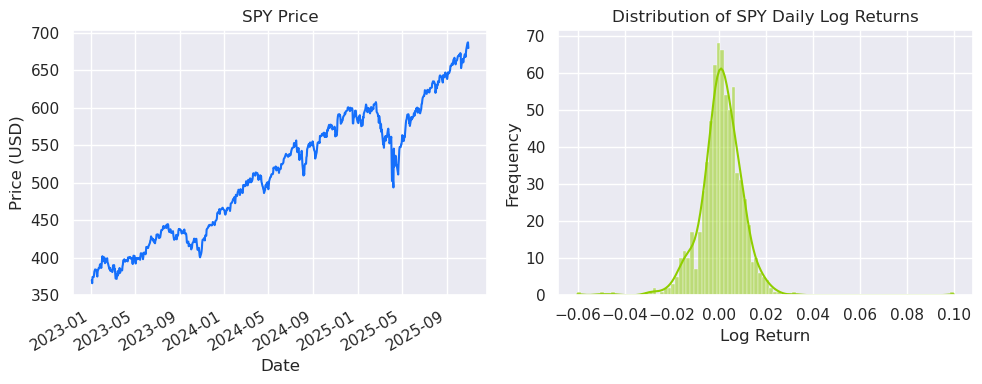

In [6]:
# Use SPY as an example
spy = all_data[['SPY']].copy().dropna()

# 1. Calculate Simple Return
spy['Returns_Simple'] = spy['SPY'].pct_change()

# 2. Calculate Log Return
spy['Returns_Log'] = np.log(spy['SPY'] / spy['SPY'].shift(1))

# Drop the first NA row (from .pct_change() and .shift())
spy = spy.dropna()

print(spy.head())

# Price chart and histogram of SPY log returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Price plot
spy['SPY'].plot(ax=ax1, title='SPY Price', color='#156ffb')
ax1.set_ylabel('Price (USD)')
ax1.grid(True)

# Histogram of log returns
sns.histplot(spy['Returns_Log'].dropna(), bins=100, kde=True, ax=ax2, color='#8fce00')
ax2.set_title('Distribution of SPY Daily Log Returns')
ax2.set_xlabel('Log Return')
ax2.set_ylabel('Frequency')
ax2.grid(True)

plt.tight_layout()
plt.show()

### 3. Rolling statistic

SMA

Visualizing SPY 50 and 200 SMA (Last 2 years):


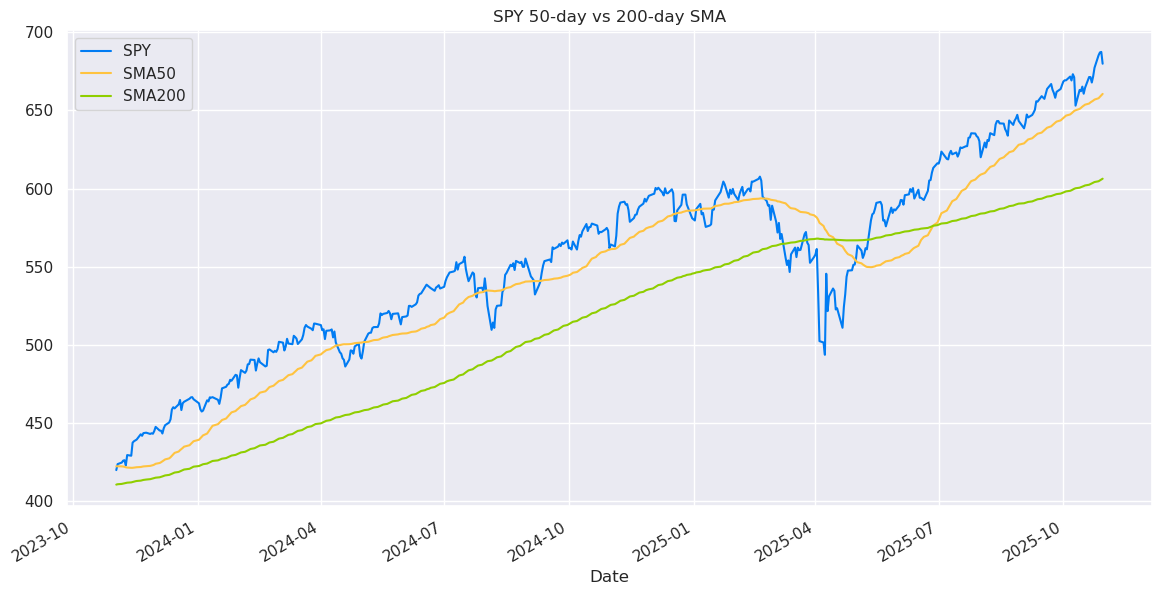

In [7]:
# Calculate 50-day and 200-day SMA for SPY
spy['SMA50'] = spy['SPY'].rolling(window=50).mean()
spy['SMA200'] = spy['SPY'].rolling(window=200).mean()

# Visualize SMA (only last 2 years for clarity)
print("Visualizing SPY 50 and 200 SMA (Last 2 years):")
spy.iloc[-500:][['SPY', 'SMA50', 'SMA200']].plot(
    title='SPY 50-day vs 200-day SMA', 
    figsize=(14, 7), 
    color={'SPY': '#017cf3', 'SMA50': '#ffc340', 'SMA200': '#8fce00'}
)
plt.show()

Volatility

Visualizing SPY 21-day Rolling Volatility (Annualized):


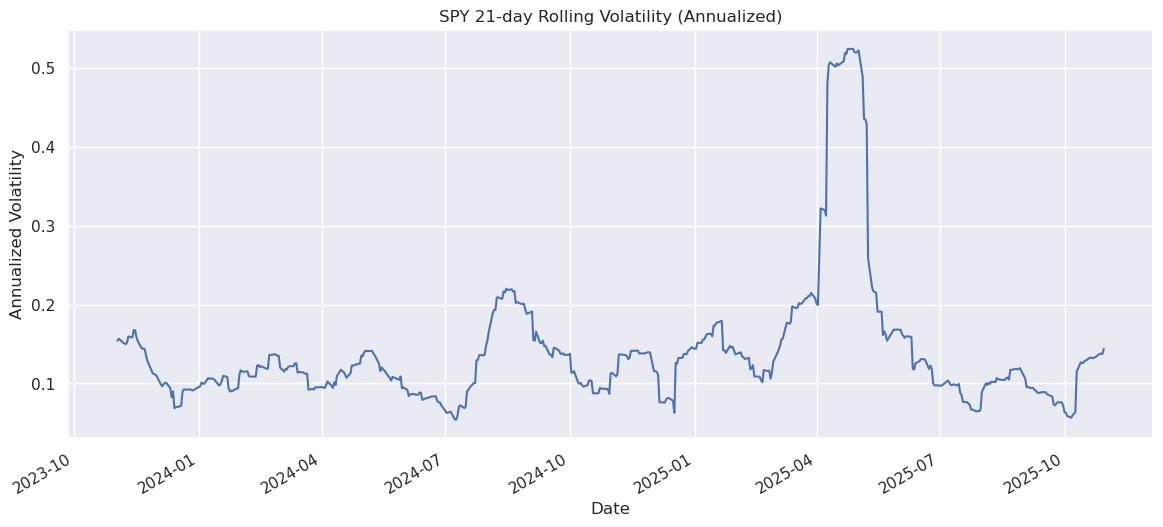

In [8]:
# Calculate 21-day rolling std dev of Log Returns
# (21 trading days ~ 1 month)
# Multiply by sqrt(252) (trading days in a year) to *annualize* it
spy['Volatility'] = spy['Returns_Log'].rolling(window=21).std() * np.sqrt(252)

print("Visualizing SPY 21-day Rolling Volatility (Annualized):")
spy['Volatility'].iloc[-500:].plot(title='SPY 21-day Rolling Volatility (Annualized)', figsize=(14, 6))
plt.ylabel('Annualized Volatility')
plt.show()

Rolling Correlation

Visualizing 60-day Rolling Correlation (AAPL vs SPY):


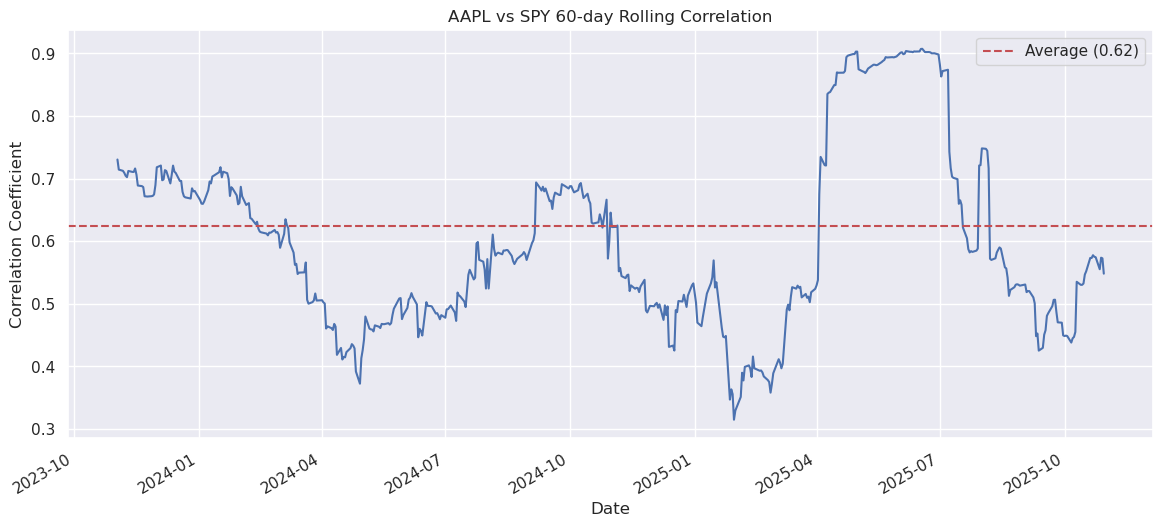

In [9]:
# Get log returns for AAPL and SPY (the market)
market_returns = np.log(all_data['SPY'] / all_data['SPY'].shift(1))
stock_returns = np.log(all_data['AAPL'] / all_data['AAPL'].shift(1))

# Calculate 60-day rolling correlation (~ 3 months)
rolling_corr = stock_returns.rolling(window=60).corr(market_returns)
rolling_corr = rolling_corr.dropna()

print("Visualizing 60-day Rolling Correlation (AAPL vs SPY):")
rolling_corr.iloc[-500:].plot(title='AAPL vs SPY 60-day Rolling Correlation', figsize=(14, 6))
plt.ylabel('Correlation Coefficient')
plt.axhline(rolling_corr.mean(), color='r', linestyle='--', label=f'Average ({rolling_corr.mean():.2f})')
plt.legend()
plt.show()

- MFI _ Money flow index
- RSI
- MACD
- SMA
- ADX
- ROC

## PART II: COMPREHENSIVE PORTFOLIO OPTIMIZZATION STRATEGY - SUMMARY

### Strategy Components Summary:

**1. Portfolio Optimization:**
- Dynamic rebalancing with rolling windows
- Risk-adjusted weight allocation
- Technical signal integration
- Position size constraints (5%-40% per asset)
- Diversification

- Choose the most optimal stock out of the portfolio

**2. Technical Analysis & Buy/Sell Signals:**
- Multi-indicator approach (RSI, MACD, Bollinger Bands, Moving Averages, Momentum)
- Signal aggregation and scoring (-1 to +1 scale)
- Adaptive position sizing based on signal strength

**3. Risk Management Framework:**
- Volatility targeting (12% annual target)
- Maximum drawdown control (15% limit)
- Stop-loss implementation (5% per position)
- Value-at-Risk monitoring
- Transaction cost consideration

### 2: PORTFOLIO OPTIMIZATION METHODS


#### 2.1 Dynamic rebalancing with rolling windows

In [10]:
# Dynamic Portfolio Optimization with Rolling Windows


def dynamic_portfolio_optimization(data, lookback_window=63, rebalance_freq=21):
    """
    Dynamic portfolio optimization with rolling windows
    
    Parameters:
    - data: Price data DataFrame
    - lookback_window: Days to look back for optimization (63 = ~3 months)
    - rebalance_freq: Rebalancing frequency in days (21 = ~1 month)
    """
    
    returns = data.pct_change().dropna()
    n_assets = len(data.columns)
    
    # Initialize portfolio weights history
    weights_history = pd.DataFrame(index=returns.index, columns=data.columns)
    portfolio_returns = pd.Series(index=returns.index, dtype=float)
    
    # Initial equal weights
    current_weights = np.array([1/n_assets] * n_assets)
    
    for i in range(lookback_window, len(returns)):
        current_date = returns.index[i]
        
        # Rebalance check
        if i % rebalance_freq == 0 or i == lookback_window:
            # Get historical data for optimization
            hist_returns = returns.iloc[i-lookback_window:i]
            
            # Calculate expected returns and covariance
            mu = hist_returns.mean() * 252
            cov = hist_returns.cov() * 252
            
            # Optimize portfolio (Max Sharpe with constraints)
            try:
                current_weights = optimize_max_sharpe_constrained(mu, cov, risk_free_rate)
            except:
                # Fallback to equal weights if optimization fails
                current_weights = np.array([1/n_assets] * n_assets)
        
        # Record weights and calculate portfolio return
        weights_history.iloc[i] = current_weights
        portfolio_returns.iloc[i] = np.dot(current_weights, returns.iloc[i])
    
    return weights_history.dropna(), portfolio_returns.dropna()


def optimize_max_sharpe_constrained(mu, cov, rf_rate=0.02, max_weight=0.4, min_weight=0.05):
    """
    Optimize portfolio for maximum Sharpe ratio with weight constraints
    """
    n_assets = len(mu)
    
    def objective(weights):
        portfolio_return = np.dot(weights, mu)
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        return -(portfolio_return - rf_rate) / portfolio_vol  # Negative for minimization
    
    # Constraints
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # Weights sum to 1
    bounds = [(min_weight, max_weight) for _ in range(n_assets)]
    
    # Initial guess
    x0 = np.array([1/n_assets] * n_assets)
    
    # Optimize
    result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        return result.x
    else:
        return np.array([1/n_assets] * n_assets)

print("Dynamic Portfolio Optimization functions defined successfully.")

# Apply dynamic optimization to our data
print("\n--- Applying Dynamic Portfolio Optimization ---")
dynamic_weights, dynamic_returns = dynamic_portfolio_optimization(train_data, lookback_window=63, rebalance_freq=21)

print(f"Dynamic optimization completed for {len(dynamic_returns)} trading days")
print("\nSample of dynamic weights (last 10 days):")
print(dynamic_weights.tail(10).round(3))

Dynamic Portfolio Optimization functions defined successfully.

--- Applying Dynamic Portfolio Optimization ---
Dynamic optimization completed for 438 trading days

Sample of dynamic weights (last 10 days):
                               AAPL      AMZN GOOGL  MSFT  SPY
Date                                                          
2024-12-17 00:00:00-05:00  0.199691  0.300309  0.05  0.05  0.4
2024-12-18 00:00:00-05:00  0.199691  0.300309  0.05  0.05  0.4
2024-12-19 00:00:00-05:00  0.199691  0.300309  0.05  0.05  0.4
2024-12-20 00:00:00-05:00  0.199691  0.300309  0.05  0.05  0.4
2024-12-23 00:00:00-05:00  0.199691  0.300309  0.05  0.05  0.4
2024-12-24 00:00:00-05:00  0.199691  0.300309  0.05  0.05  0.4
2024-12-26 00:00:00-05:00  0.199691  0.300309  0.05  0.05  0.4
2024-12-27 00:00:00-05:00  0.199691  0.300309  0.05  0.05  0.4
2024-12-30 00:00:00-05:00  0.199691  0.300309  0.05  0.05  0.4
2024-12-31 00:00:00-05:00  0.199691  0.300309  0.05  0.05  0.4


#### 2.2 Kelly Criterion Dynamic Portfolio Optimization

In [11]:
# Kelly Criterion Portfolio Optimization

def kelly_criterion_optimization(mu, cov, confidence_level=0.6):
    """
    Kelly Criterion portfolio optimization
    
    Formula: f = (bp - q) / b
    Where:
    - f = fraction of capital to bet
    - b = odds received (return/risk ratio)
    - p = probability of winning
    - q = probability of losing (1-p)
    """
    n_assets = len(mu)
    kelly_weights = np.zeros(n_assets)
    
    # Calculate individual asset Kelly fractions
    volatilities = np.sqrt(np.diag(cov))
    
    for i in range(n_assets):
        if volatilities[i] > 0 and mu[i] > 0:
            # Estimate win probability based on Sharpe ratio
            sharpe = mu[i] / volatilities[i]
            win_prob = min(0.5 + sharpe * 0.1, 0.85)  # Cap at 85%
            
            # Kelly fraction calculation
            odds_ratio = mu[i] / volatilities[i]  # Return to risk ratio
            kelly_fraction = (odds_ratio * win_prob - (1 - win_prob)) / odds_ratio
            
            # Apply conservative scaling (fractional Kelly)
            kelly_weights[i] = max(0, kelly_fraction * 0.25)  # Use 25% of full Kelly
    
    # Normalize weights to sum to 1
    if kelly_weights.sum() > 0:
        kelly_weights = kelly_weights / kelly_weights.sum()
    else:
        kelly_weights = np.array([1/n_assets] * n_assets)  # Equal weights fallback
    
    return kelly_weights

def dynamic_kelly_optimization(data, lookback_window=63, rebalance_freq=21):
    """
    Dynamic Kelly Criterion optimization with rolling windows
    """
    returns = data.pct_change().dropna()
    n_assets = len(data.columns)
    
    # Initialize tracking
    weights_history = pd.DataFrame(index=returns.index, columns=data.columns)
    portfolio_returns = pd.Series(index=returns.index, dtype=float)
    
    # Initial equal weights
    current_weights = np.array([1/n_assets] * n_assets)
    
    for i in range(lookback_window, len(returns)):
        current_date = returns.index[i]
        
        # Rebalance check
        if i % rebalance_freq == 0 or i == lookback_window:
            # Get historical data
            hist_returns = returns.iloc[i-lookback_window:i]
            
            # Calculate expected returns and covariance
            mu = hist_returns.mean() * 252
            cov = hist_returns.cov() * 252
            
            # Optimize using Kelly Criterion
            try:
                current_weights = kelly_criterion_optimization(mu, cov)
            except:
                current_weights = np.array([1/n_assets] * n_assets)
        
        # Record weights and calculate portfolio return
        weights_history.iloc[i] = current_weights
        portfolio_returns.iloc[i] = np.dot(current_weights, returns.iloc[i])
    
    return weights_history.dropna(), portfolio_returns.dropna()

print("Kelly Criterion optimization functions defined successfully.")

# Apply Kelly optimization to our data
print("\n--- Applying Kelly Criterion Dynamic Portfolio Optimization ---")
kelly_weights, kelly_returns = dynamic_kelly_optimization(train_data, lookback_window=63, rebalance_freq=21)

print(f"Kelly optimization completed for {len(kelly_returns)} trading days")
print("\nSample of Kelly weights (last 10 days):")
print(kelly_weights.tail(10).round(3))

Kelly Criterion optimization functions defined successfully.

--- Applying Kelly Criterion Dynamic Portfolio Optimization ---
Kelly optimization completed for 438 trading days

Sample of Kelly weights (last 10 days):
                               AAPL      AMZN     GOOGL      MSFT       SPY
Date                                                                       
2024-12-17 00:00:00-05:00  0.180873  0.243532  0.171131  0.133622  0.270842
2024-12-18 00:00:00-05:00  0.180873  0.243532  0.171131  0.133622  0.270842
2024-12-19 00:00:00-05:00  0.180873  0.243532  0.171131  0.133622  0.270842
2024-12-20 00:00:00-05:00  0.180873  0.243532  0.171131  0.133622  0.270842
2024-12-23 00:00:00-05:00  0.180873  0.243532  0.171131  0.133622  0.270842
2024-12-24 00:00:00-05:00  0.180873  0.243532  0.171131  0.133622  0.270842
2024-12-26 00:00:00-05:00  0.180873  0.243532  0.171131  0.133622  0.270842
2024-12-27 00:00:00-05:00  0.180873  0.243532  0.171131  0.133622  0.270842
2024-12-30 00:00:00-05:

#### 2.3 Risk Parity Dynamic Portfolio Optimization

In [12]:
# Risk Parity Portfolio Optimization

def risk_parity_optimization(cov, max_iterations=1000, tolerance=1e-8):
    """
    Risk Parity portfolio optimization using iterative algorithm
    
    Objective: Each asset contributes equally to portfolio risk
    """
    n_assets = len(cov)
    
    # Start with equal weights
    weights = np.array([1/n_assets] * n_assets)
    
    # Iterative algorithm to find risk parity weights
    for iteration in range(max_iterations):
        # Calculate risk contributions
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        marginal_risk = np.dot(cov, weights) / portfolio_vol
        risk_contributions = weights * marginal_risk
        
        # Target risk contribution (equal for all assets)
        target_risk = portfolio_vol ** 2 / n_assets
        
        # Update weights based on risk contribution differences
        risk_diff = risk_contributions - target_risk
        
        # Convergence check
        if np.max(np.abs(risk_diff)) < tolerance:
            break
        
        # Update weights (move away from over-contributing assets)
        adjustment_factor = 0.05  # Learning rate
        weight_updates = -adjustment_factor * risk_diff / marginal_risk
        weights = weights + weight_updates
        
        # Ensure non-negative weights and renormalize
        weights = np.maximum(weights, 1e-8)
        weights = weights / weights.sum()
    
    return weights

def dynamic_risk_parity_optimization(data, lookback_window=63, rebalance_freq=21):
    """
    Dynamic Risk Parity optimization with rolling windows
    """
    returns = data.pct_change().dropna()
    n_assets = len(data.columns)
    
    # Initialize tracking
    weights_history = pd.DataFrame(index=returns.index, columns=data.columns)
    portfolio_returns = pd.Series(index=returns.index, dtype=float)
    
    # Initial equal weights
    current_weights = np.array([1/n_assets] * n_assets)
    
    for i in range(lookback_window, len(returns)):
        current_date = returns.index[i]
        
        # Rebalance check
        if i % rebalance_freq == 0 or i == lookback_window:
            # Get historical data
            hist_returns = returns.iloc[i-lookback_window:i]
            
            # Calculate covariance matrix
            cov = hist_returns.cov() * 252
            
            # Optimize using Risk Parity
            try:
                # Check if covariance matrix is valid
                eigenvals = np.linalg.eigvals(cov)
                if np.all(eigenvals > 0):
                    current_weights = risk_parity_optimization(cov)
                else:
                    # Fallback: use correlation matrix with equal volatilities
                    corr = hist_returns.corr()
                    vol_avg = hist_returns.std().mean() * np.sqrt(252)
                    cov_regularized = corr * (vol_avg ** 2)
                    current_weights = risk_parity_optimization(cov_regularized)
            except:
                current_weights = np.array([1/n_assets] * n_assets)
        
        # Record weights and calculate portfolio return
        weights_history.iloc[i] = current_weights
        portfolio_returns.iloc[i] = np.dot(current_weights, returns.iloc[i])
    
    return weights_history.dropna(), portfolio_returns.dropna()

print("Risk Parity optimization functions defined successfully.")

# Apply Risk Parity optimization to our data
print("\n--- Applying Risk Parity Dynamic Portfolio Optimization ---")
rp_weights, rp_returns = dynamic_risk_parity_optimization(train_data, lookback_window=63, rebalance_freq=21)

print(f"Risk Parity optimization completed for {len(rp_returns)} trading days")
print("\nSample of Risk Parity weights (last 10 days):")
print(rp_weights.tail(10).round(3))

Risk Parity optimization functions defined successfully.

--- Applying Risk Parity Dynamic Portfolio Optimization ---
Risk Parity optimization completed for 438 trading days

Sample of Risk Parity weights (last 10 days):
                               AAPL      AMZN     GOOGL      MSFT      SPY
Date                                                                      
2024-12-17 00:00:00-05:00  0.229572  0.126301  0.169763  0.167054  0.30731
2024-12-18 00:00:00-05:00  0.229572  0.126301  0.169763  0.167054  0.30731
2024-12-19 00:00:00-05:00  0.229572  0.126301  0.169763  0.167054  0.30731
2024-12-20 00:00:00-05:00  0.229572  0.126301  0.169763  0.167054  0.30731
2024-12-23 00:00:00-05:00  0.229572  0.126301  0.169763  0.167054  0.30731
2024-12-24 00:00:00-05:00  0.229572  0.126301  0.169763  0.167054  0.30731
2024-12-26 00:00:00-05:00  0.229572  0.126301  0.169763  0.167054  0.30731
2024-12-27 00:00:00-05:00  0.229572  0.126301  0.169763  0.167054  0.30731
2024-12-30 00:00:00-05:00  0.

#### 2.4 Optimize $k$-of-$n$ assets (Max Sharpe)

In [13]:
print(f"--- STARTING k-of-n SEARCH (Max Sharpe) on Train Set ---")
train_returns = train_data.pct_change().dropna()

# 1. Global tracking variables
global_best_sharpe_k = -np.inf
global_best_weights_k_sharpe = None
all_results_sharpe = [] 

# 2. Calculate base metrics (from mu_train, S_train already calculated in 2.2)
individual_vol_series_train = pd.Series(np.sqrt(np.diag(cov_train)), index=tickers)
individual_sharpes_train = (return_train - risk_free_rate) / individual_vol_series_train
individual_vol_train = individual_vol_series_train.to_dict()

# 3. Outer loop: Iterate k from 1 to n
for k in range(1, n + 1):
    # 4. Inner loop: Iterate combinations C(n, k)
    for combo in itertools.combinations(tickers, k):
        combo_list = list(combo)
        combo_str = str(combo)
        ret, vol, sharpe, weights_dict = (np.nan, np.nan, np.nan, {})

        try:
            # 5. Optimize for this combination
            if k == 1:
                ticker = combo_list[0]
                ret = return_train[ticker]
                vol = individual_vol_train[ticker]
                sharpe = individual_sharpes_train[ticker]
                weights_dict = {ticker: 1.0}
            else:
                mu_combo = return_train[combo_list]
                S_combo = cov_train.loc[combo_list, combo_list]
                ef_combo = EfficientFrontier(mu_combo, S_combo, weight_bounds=(0, 1))
                weights = ef_combo.max_sharpe(risk_free_rate=risk_free_rate)
                ret, vol, sharpe = ef_combo.portfolio_performance(risk_free_rate=risk_free_rate)
                weights_dict = ef_combo.clean_weights()

            # 6. Track results
            if sharpe > global_best_sharpe_k:
                global_best_sharpe_k = sharpe
                global_best_weights_k_sharpe = weights_dict
            
            all_results_sharpe.append({'k': k, 'Combination': combo_str, 'Sharpe': sharpe, 'Volatility': vol, 'Return (APY)': ret, 'Weights': weights_dict})
        except Exception as e:
            pass 

# 7. Print final results
print("\n================ OPTIMAL RESULT (k-Max Sharpe) - TRAINING ================")
print(f"Highest Global Sharpe: {global_best_sharpe_k:.4f} (with k={len(global_best_weights_k_sharpe)}) ")
print("Static Weights found (k-MaxSharpe):")
print(pd.Series(global_best_weights_k_sharpe))

# 8. Print all results dataframe
all_results_sharpe_df = pd.DataFrame(all_results_sharpe).sort_values(by='Sharpe', ascending=False).reset_index(drop=True)
print("\n--- Top 15 Combinations (Ranked by Sharpe) ---")
print(all_results_sharpe_df[['k', 'Combination', 'Sharpe', 'Volatility']].head(15))

--- STARTING k-of-n SEARCH (Max Sharpe) on Train Set ---

================ OPTIMAL RESULT (k-Max Sharpe) - TRAINING ================
Highest Global Sharpe: 2.5725 (with k=1) 
Static Weights found (k-MaxSharpe):
AMZN    1.0
dtype: float64

--- Top 15 Combinations (Ranked by Sharpe) ---
    k                               Combination    Sharpe  Volatility
0   1                                 ('AMZN',)  2.572460    0.226776
1   5  ('AAPL', 'MSFT', 'GOOGL', 'AMZN', 'SPY')  2.294902    0.189392
2   4          ('AAPL', 'GOOGL', 'AMZN', 'SPY')  2.294902    0.189392
3   3                   ('AAPL', 'AMZN', 'SPY')  2.291674    0.188069
4   4           ('AAPL', 'MSFT', 'AMZN', 'SPY')  2.291674    0.188069
5   3                 ('AAPL', 'GOOGL', 'AMZN')  2.288599    0.207640
6   4         ('AAPL', 'MSFT', 'GOOGL', 'AMZN')  2.288599    0.207640
7   2                          ('AAPL', 'AMZN')  2.282829    0.209772
8   3                  ('AAPL', 'MSFT', 'AMZN')  2.282829    0.209772
9   4         

#### 2.5 Optimize $k$-of-$n$ assets (Min Volatility)

In [14]:
print(f"--- STARTING k-of-n SEARCH (Min Volatility) on Train Set ---")

# 1. Global tracking variables
global_best_vol_k = np.inf
global_best_weights_k_vol = None
all_results_vol = [] 

# (No need to recalculate individual_vol_train, use from 2.6)

# 3. Outer loop: Iterate k from 1 to n
for k in range(1, n + 1):
    # 4. Inner loop: Iterate combinations C(n, k)
    for combo in itertools.combinations(tickers, k):
        combo_list = list(combo)
        combo_str = str(combo)
        ret, vol, sharpe, weights_dict = (np.nan, np.nan, np.nan, {})

        try:
            if k == 1:
                ticker = combo_list[0]
                ret = return_train[ticker]
                vol = individual_vol_train[ticker]
                sharpe = individual_sharpes_train[ticker]
                weights_dict = {ticker: 1.0}
            else:
                mu_combo = return_train[combo_list]
                S_combo = cov_train.loc[combo_list, combo_list]
                ef_combo = EfficientFrontier(mu_combo, S_combo, weight_bounds=(0, 1))
                weights = ef_combo.min_volatility() # <-- CHANGE OBJECTIVE
                ret, vol, sharpe = ef_combo.portfolio_performance(risk_free_rate=risk_free_rate)
                weights_dict = ef_combo.clean_weights()

            # 6. Track results (CHANGE OBJECTIVE)
            if vol < global_best_vol_k:
                global_best_vol_k = vol
                global_best_weights_k_vol = weights_dict
            
            all_results_vol.append({'k': k, 'Combination': combo_str, 'Sharpe': sharpe, 'Volatility': vol, 'Return (APY)': ret, 'Weights': weights_dict})
        except Exception as e:
            pass 

# 7. Print final results
print("\n================ OPTIMAL RESULT (k-Min Vol) - TRAINING ================")
print(f"Lowest Global Volatility: {global_best_vol_k:.4f} (with k={len(global_best_weights_k_vol)}) ")
print("Static Weights found (k-MinVol):")
print(pd.Series(global_best_weights_k_vol))

# 8. Print all results dataframe
all_results_vol_df = pd.DataFrame(all_results_vol).sort_values(by='Volatility', ascending=True).reset_index(drop=True)
print("\n--- Top 15 Combinations (Ranked by Volatility) ---")
print(all_results_vol_df[['k', 'Combination', 'Volatility', 'Sharpe']].head())

--- STARTING k-of-n SEARCH (Min Volatility) on Train Set ---

================ OPTIMAL RESULT (k-Min Vol) - TRAINING ================
Lowest Global Volatility: 0.1282 (with k=3) 
Static Weights found (k-MinVol):
MSFT    0.0
AMZN    0.0
SPY     1.0
dtype: float64

--- Top 15 Combinations (Ranked by Volatility) ---
   k                               Combination  Volatility    Sharpe
0  3                   ('MSFT', 'AMZN', 'SPY')    0.128186  1.869747
1  1                                  ('SPY',)    0.128186  1.869747
2  5  ('AAPL', 'MSFT', 'GOOGL', 'AMZN', 'SPY')    0.128186  1.869747
3  4          ('MSFT', 'GOOGL', 'AMZN', 'SPY')    0.128186  1.869747
4  2                          ('GOOGL', 'SPY')    0.128186  1.869747


#### 2.6 Strategy Comparison on Train test

=== RUNNING ALL DYNAMIC OPTIMIZATION METHODS ===
=== COMPREHENSIVE DYNAMIC PORTFOLIO OPTIMIZATION ===
Running Max Sharpe optimization...
Running Kelly Criterion optimization...
Running Risk Parity optimization...

Dynamic Optimization Results:
Methods implemented: ['Max_Sharpe_Dynamic', 'Kelly_Dynamic', 'Risk_Parity_Dynamic']
Trading days analyzed: 438

Recent Performance (Last 10 days):
                           Max_Sharpe_Dynamic  Kelly_Dynamic  Risk_Parity_Dynamic
Date                                                                             
2024-12-17 00:00:00-05:00             -0.0020        -0.0014              -0.0000
2024-12-18 00:00:00-05:00             -0.0337        -0.0343              -0.0323
2024-12-19 00:00:00-05:00              0.0050         0.0042               0.0031
2024-12-20 00:00:00-05:00              0.0115         0.0109               0.0114
2024-12-23 00:00:00-05:00              0.0039         0.0048               0.0050
2024-12-24 00:00:00-05:00          

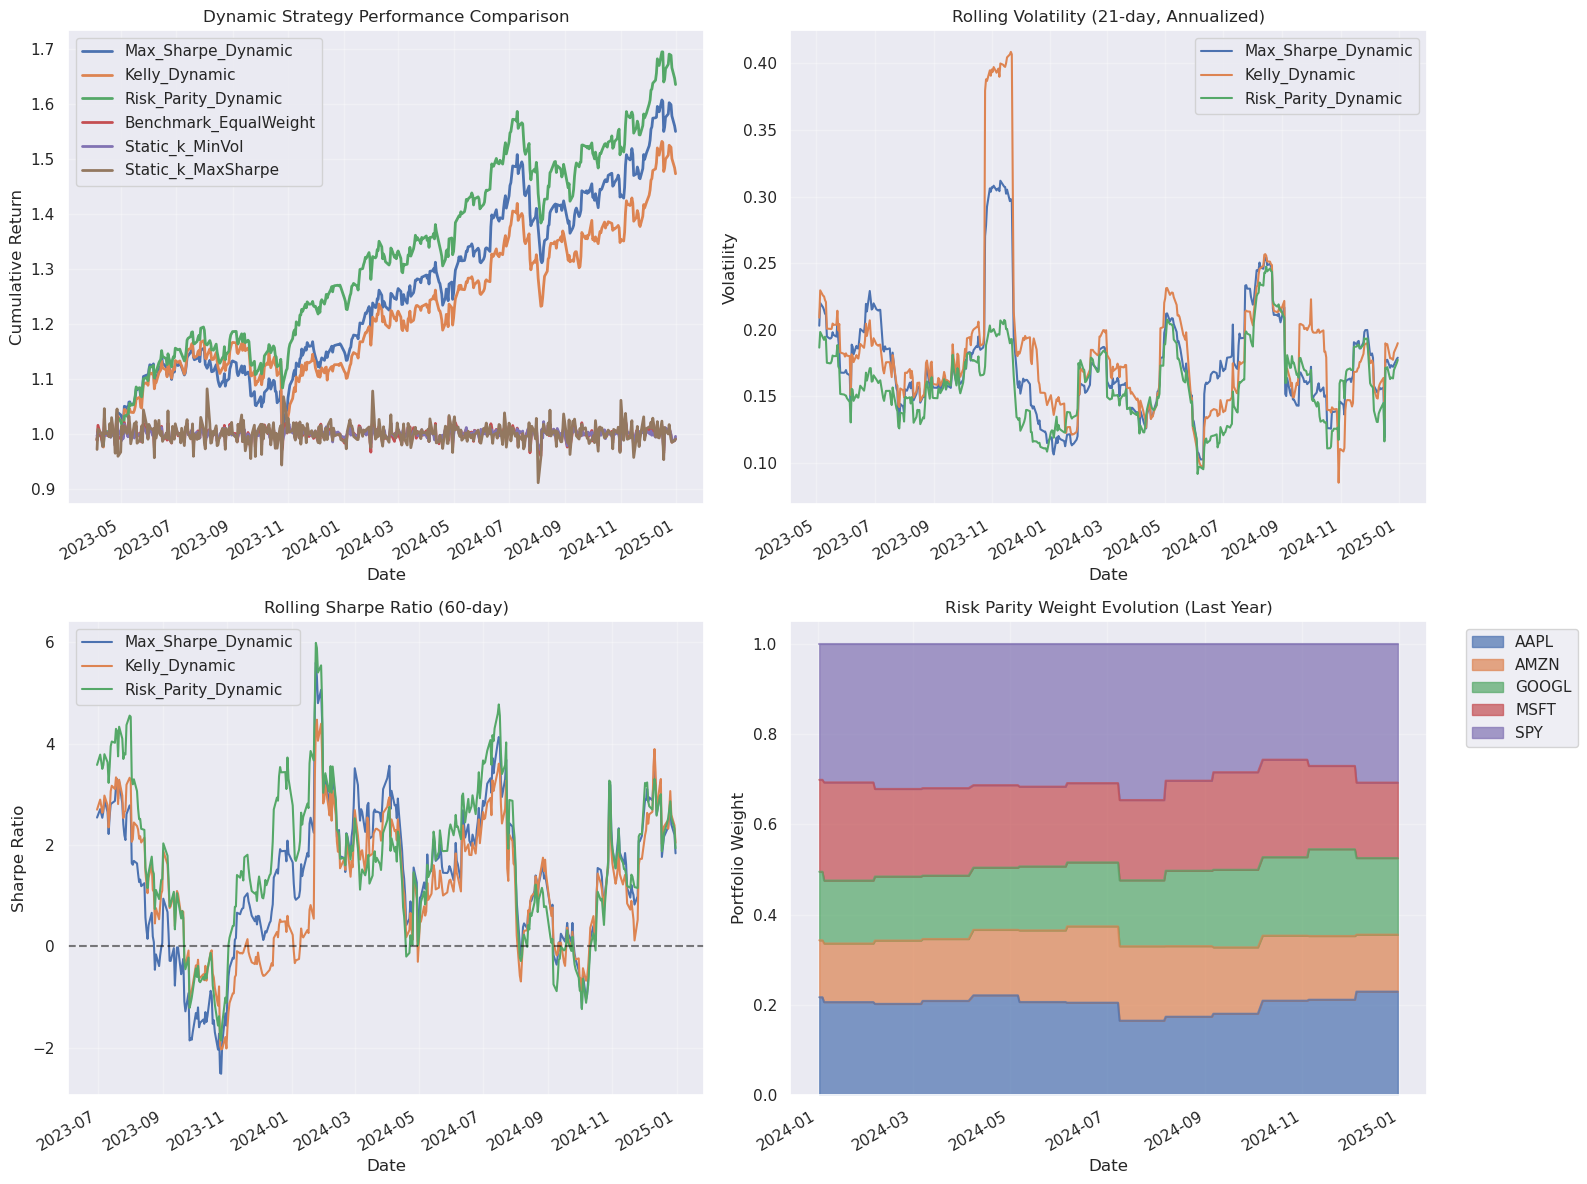


=== DYNAMIC STRATEGY PERFORMANCE METRICS ===

Performance Metrics Summary:
                     Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown  Calmar Ratio  Sortino Ratio  Skewness  Kurtosis  VaR (95%)  CVaR (95%)
Max_Sharpe_Dynamic          0.3077             0.1792        1.6052       -0.1439        2.1382         2.1598   -0.6137    2.2337    -0.0176     -0.0257
Kelly_Dynamic               0.2732             0.1921        1.3183       -0.1478        1.8489         1.6323   -1.2802    8.8901    -0.0187     -0.0279
Risk_Parity_Dynamic         0.3446             0.1618        2.0061       -0.1278        2.6967         2.7994   -0.4647    0.7560    -0.0179     -0.0233

Strategy Rankings (by Sharpe Ratio):
  1. Risk_Parity_Dynamic      :  2.0061
  2. Max_Sharpe_Dynamic       :  1.6052
  3. Kelly_Dynamic            :  1.3183

Key Insights:
  • Kelly Criterion: Optimized for long-term growth rate
  • Risk Parity: Equal risk contribution from all assets
  • Max Sharpe: Tradi

In [22]:
# Comprehensive Dynamic Strategy Comparison
equal_weights = {ticker: (1/n) for ticker in tickers}

def comprehensive_dynamic_optimization(data, lookback_window=63, rebalance_freq=21):
    """
    Compare multiple dynamic optimization methods
    """
    print("=== COMPREHENSIVE DYNAMIC PORTFOLIO OPTIMIZATION ===")
    
    # Run all optimization methods
    methods = {}
    
    # 1. Maximum Sharpe (existing)
    print("Running Max Sharpe optimization...")
    methods['Max_Sharpe_Dynamic'] = dynamic_portfolio_optimization(
        data, lookback_window, rebalance_freq
    )
    
    # 2. Kelly Criterion
    print("Running Kelly Criterion optimization...")
    methods['Kelly_Dynamic'] = dynamic_kelly_optimization(
        data, lookback_window, rebalance_freq
    )
    
    # 3. Risk Parity
    print("Running Risk Parity optimization...")
    methods['Risk_Parity_Dynamic'] = dynamic_risk_parity_optimization(
        data, lookback_window, rebalance_freq
    )
    
    return methods

# Implementation
print("=== RUNNING ALL DYNAMIC OPTIMIZATION METHODS ===")

# Run comprehensive optimization
optimization_results = comprehensive_dynamic_optimization(
    train_data, lookback_window=63, rebalance_freq=21
)

# Extract results for comparison
dynamic_strategies = {}
for method_name, (weights, returns) in optimization_results.items():
    dynamic_strategies[method_name] = returns

# Convert to DataFrame for analysis
dynamic_returns_df = pd.DataFrame(dynamic_strategies)

print(f"\nDynamic Optimization Results:")
print(f"Methods implemented: {list(dynamic_strategies.keys())}")
print(f"Trading days analyzed: {len(dynamic_returns_df)}")

# Performance comparison
print("\nRecent Performance (Last 10 days):")
print(dynamic_returns_df.tail(10).round(4))

# Visualize results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cumulative Performance
cumulative_performance = (1 + dynamic_returns_df).cumprod()

cumulative_performance['Benchmark_EqualWeight'] = 1 + (train_returns * pd.Series(equal_weights)).sum(axis=1)
cumulative_performance['Static_k_MinVol'] = 1 + (train_returns[global_best_weights_k_vol.keys()] * pd.Series(global_best_weights_k_vol)).sum(axis=1)
cumulative_performance['Static_k_MaxSharpe'] = 1 + (train_returns[global_best_weights_k_sharpe.keys()] * pd.Series(global_best_weights_k_sharpe)).sum(axis=1)

cumulative_performance.plot(ax=ax1, linewidth=2)
ax1.set_title('Dynamic Strategy Performance Comparison')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Rolling Volatility (21-day)
rolling_vol = dynamic_returns_df.rolling(21).std() * np.sqrt(252)
rolling_vol.plot(ax=ax2, linewidth=1.5)
ax2.set_title('Rolling Volatility (21-day, Annualized)')
ax2.set_ylabel('Volatility')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Rolling Sharpe Ratio (60-day)
rolling_sharpe = pd.DataFrame()
for col in dynamic_returns_df.columns:
    rolling_returns = dynamic_returns_df[col].rolling(60)
    rolling_sharpe[col] = (rolling_returns.mean() * 252 - risk_free_rate) / (rolling_returns.std() * np.sqrt(252))

rolling_sharpe.plot(ax=ax3, linewidth=1.5)
ax3.set_title('Rolling Sharpe Ratio (60-day)')
ax3.set_ylabel('Sharpe Ratio')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Weight Evolution (for Risk Parity)
if 'Risk_Parity_Dynamic' in optimization_results:
    rp_weights, _ = optimization_results['Risk_Parity_Dynamic']
    rp_weights.iloc[-252:].plot(ax=ax4, kind='area', stacked=True, alpha=0.7)
    ax4.set_title('Risk Parity Weight Evolution (Last Year)')
    ax4.set_ylabel('Portfolio Weight')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics calculation function
def calculate_comprehensive_metrics(returns_series, rf_rate=0.02):
    """Calculate comprehensive performance metrics"""
    if returns_series.empty or returns_series.std() == 0:
        return pd.Series({
            "Annual Return": 0, "Annual Volatility": 0, "Sharpe Ratio": 0,
            "Max Drawdown": 0, "Calmar Ratio": 0, "Sortino Ratio": 0,
            "Skewness": 0, "Kurtosis": 0, "VaR (95%)": 0, "CVaR (95%)": 0
        })
    
    # Basic metrics
    annual_return = (1 + returns_series.mean()) ** 252 - 1
    annual_volatility = returns_series.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - rf_rate) / annual_volatility
    
    # Drawdown metrics
    cumulative = (1 + returns_series).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Downside risk metrics
    negative_returns = returns_series[returns_series < 0]
    downside_deviation = negative_returns.std() * np.sqrt(252) if len(negative_returns) > 0 else 0
    sortino_ratio = (annual_return - rf_rate) / downside_deviation if downside_deviation != 0 else 0
    
    # Distribution metrics
    skewness = returns_series.skew()
    kurtosis = returns_series.kurtosis()
    
    # Risk metrics
    var_95 = returns_series.quantile(0.05)
    cvar_95 = returns_series[returns_series <= var_95].mean()
    
    return pd.Series({
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio,
        "Sortino Ratio": sortino_ratio,
        "Skewness": skewness,
        "Kurtosis": kurtosis,
        "VaR (95%)": var_95,
        "CVaR (95%)": cvar_95
    })

# Performance metrics comparison
print("\n=== DYNAMIC STRATEGY PERFORMANCE METRICS ===")
dynamic_metrics = {}
for strategy in dynamic_returns_df.columns:
    dynamic_metrics[strategy] = calculate_comprehensive_metrics(dynamic_returns_df[strategy])

dynamic_metrics_df = pd.DataFrame(dynamic_metrics).T
print("\nPerformance Metrics Summary:")
print(dynamic_metrics_df.round(4).to_string())

# Rank by Sharpe ratio
print(f"\nStrategy Rankings (by Sharpe Ratio):")
sharpe_ranking = dynamic_metrics_df['Sharpe Ratio'].sort_values(ascending=False)
for i, (strategy, sharpe) in enumerate(sharpe_ranking.items(), 1):
    print(f"  {i}. {strategy:25}: {sharpe:7.4f}")

print(f"\nKey Insights:")
print(f"  • Kelly Criterion: Optimized for long-term growth rate")
print(f"  • Risk Parity: Equal risk contribution from all assets")
print(f"  • Max Sharpe: Traditional risk-adjusted return optimization")
print(f"  • All methods use same rolling window framework for fair comparison")

#### 2.7 Compare the trading result tested on test section (Back test)
Metrics Analysis & Conclusion

=== COMPREHENSIVE DYNAMIC PORTFOLIO OPTIMIZATION ===
Running Max Sharpe optimization...
Running Kelly Criterion optimization...
Running Risk Parity optimization...

Dynamic Optimization Results:
Methods implemented: ['Max_Sharpe_Dynamic', 'Kelly_Dynamic', 'Risk_Parity_Dynamic']
Trading days analyzed: 39

Recent Performance (Last 10 days):
                           Max_Sharpe_Dynamic  Kelly_Dynamic  Risk_Parity_Dynamic
Date                                                                             
2025-05-16 00:00:00-04:00              0.0042         0.0025               0.0050
2025-05-19 00:00:00-04:00              0.0036         0.0101               0.0015
2025-05-20 00:00:00-04:00             -0.0042        -0.0015              -0.0075
2025-05-21 00:00:00-04:00             -0.0133        -0.0122              -0.0072
2025-05-22 00:00:00-04:00              0.0030         0.0051               0.0051
2025-05-23 00:00:00-04:00             -0.0111        -0.0103              -0.0136
202

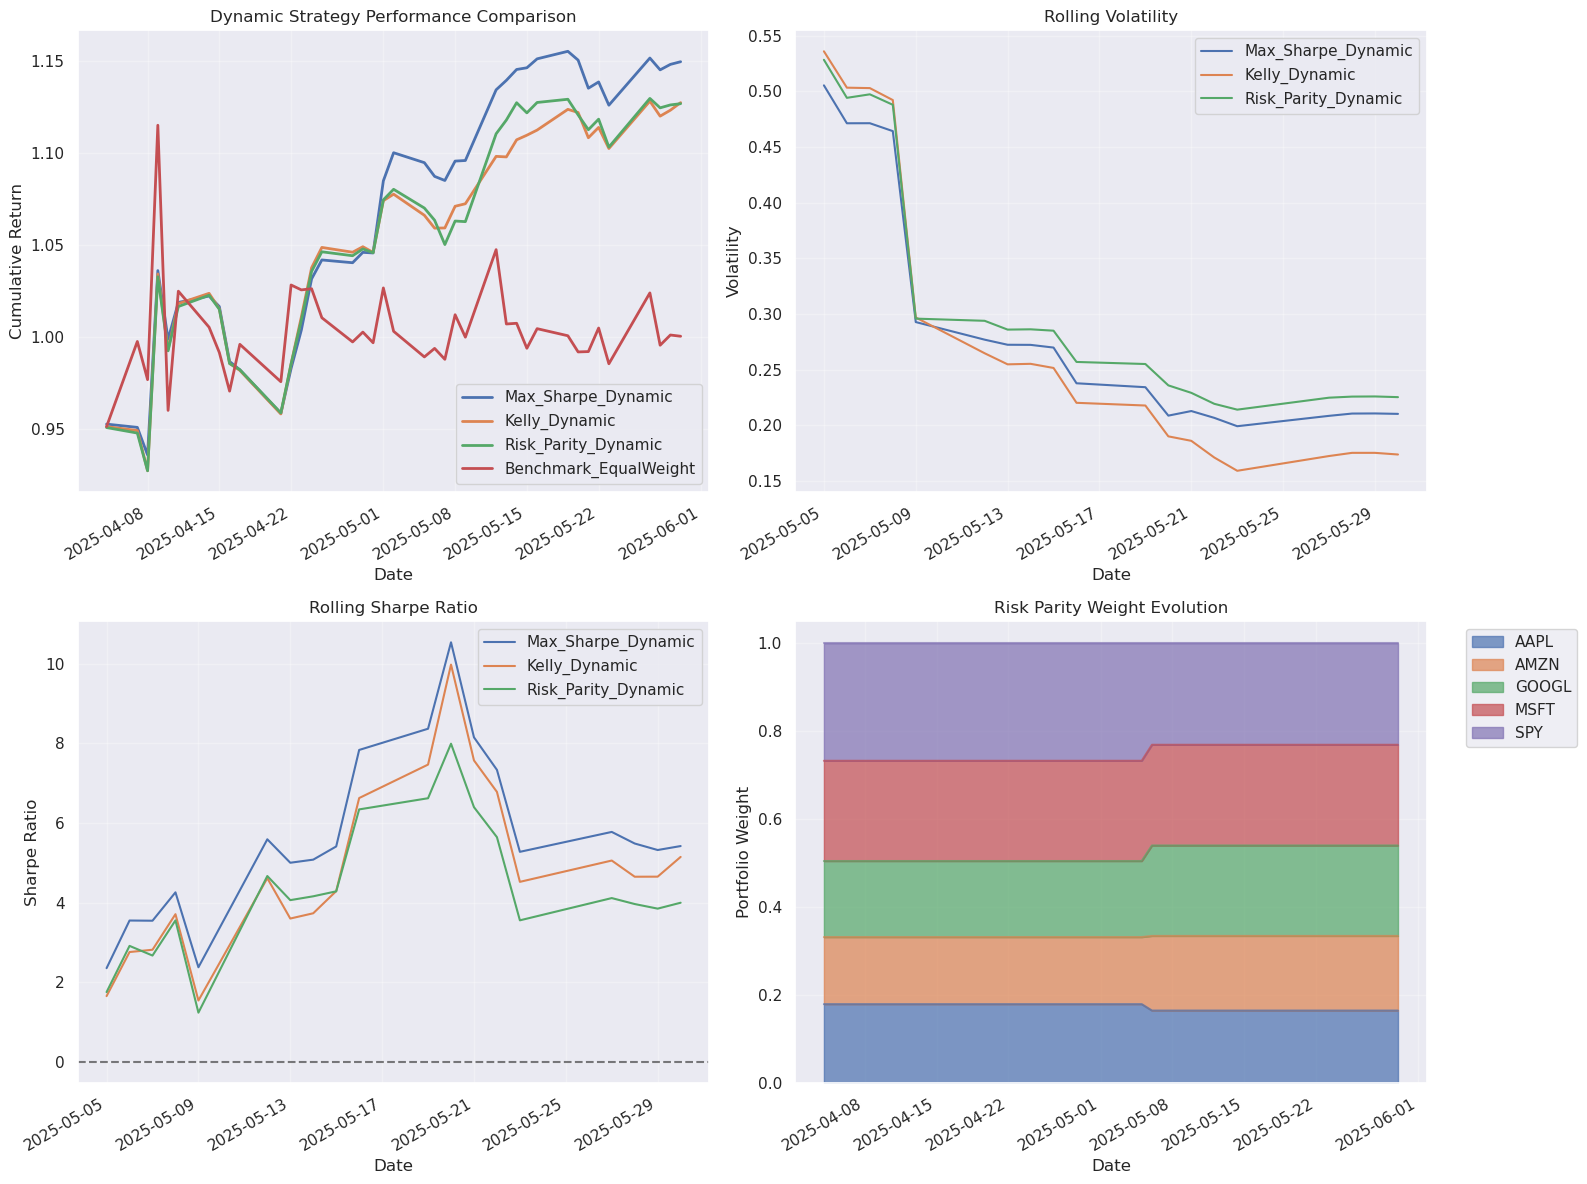

In [29]:
validation_returns = validation_data.pct_change().dropna()
# Run comprehensive optimization
optimization_results = comprehensive_dynamic_optimization(
    validation_data, lookback_window=63, rebalance_freq=21
)

# Extract results for comparison
dynamic_strategies = {}
for method_name, (weights, returns) in optimization_results.items():
    dynamic_strategies[method_name] = returns

# Convert to DataFrame for analysis
dynamic_returns_df = pd.DataFrame(dynamic_strategies)

print(f"\nDynamic Optimization Results:")
print(f"Methods implemented: {list(dynamic_strategies.keys())}")
print(f"Trading days analyzed: {len(dynamic_returns_df)}")

# Performance comparison
print("\nRecent Performance (Last 10 days):")
print(dynamic_returns_df.tail(10).round(4))

# Visualize results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cumulative Performance
cumulative_performance = (1 + dynamic_returns_df).cumprod()

cumulative_performance['Benchmark_EqualWeight'] = 1+ (validation_returns * pd.Series(equal_weights)).sum(axis=1)

cumulative_performance.plot(ax=ax1, linewidth=2)
ax1.set_title('Dynamic Strategy Performance Comparison')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Rolling Volatility (21-day)
rolling_vol = dynamic_returns_df.rolling(21).std() * np.sqrt(252)
rolling_vol.plot(ax=ax2, linewidth=1.5)
ax2.set_title('Rolling Volatility')
ax2.set_ylabel('Volatility')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Rolling Sharpe Ratio (60-day)
rolling_sharpe = pd.DataFrame()
for col in dynamic_returns_df.columns:
    rolling_returns = dynamic_returns_df[col].rolling(21)
    rolling_sharpe[col] = (rolling_returns.mean() * 252 - risk_free_rate) / (rolling_returns.std() * np.sqrt(252))

rolling_sharpe.plot(ax=ax3, linewidth=1.5)
ax3.set_title('Rolling Sharpe Ratio')
ax3.set_ylabel('Sharpe Ratio')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Weight Evolution (for Risk Parity)
if 'Risk_Parity_Dynamic' in optimization_results:
    rp_weights, _ = optimization_results['Risk_Parity_Dynamic']
    rp_weights.iloc[-252:].plot(ax=ax4, kind='area', stacked=True, alpha=0.7)
    ax4.set_title('Risk Parity Weight Evolution')
    ax4.set_ylabel('Portfolio Weight')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
dynamic_weights, dynamic_returns = dynamic_portfolio_optimization(test_data, lookback_window=63, rebalance_freq=21)
dynamic_weights

,AAPL,AMZN,GOOGL,MSFT,SPY
Date,,,,,
2025-05-05 00:00:00-04:00,0.1,0.05,0.05,0.4,0.4
2025-05-06 00:00:00-04:00,0.1,0.05,0.05,0.4,0.4
2025-05-07 00:00:00-04:00,0.1,0.05,0.05,0.4,0.4
2025-05-08 00:00:00-04:00,0.1,0.05,0.05,0.4,0.4
2025-05-09 00:00:00-04:00,0.1,0.05,0.05,0.4,0.4
...,...,...,...,...,...
2025-10-24 00:00:00-04:00,0.176398,0.05,0.4,0.05,0.323602
2025-10-27 00:00:00-04:00,0.176398,0.05,0.4,0.05,0.323602
2025-10-28 00:00:00-04:00,0.176398,0.05,0.4,0.05,0.323602


## PART III: TECHNICAL ANALYSIS FOR SELL/BUY (RECOMMENDATION)

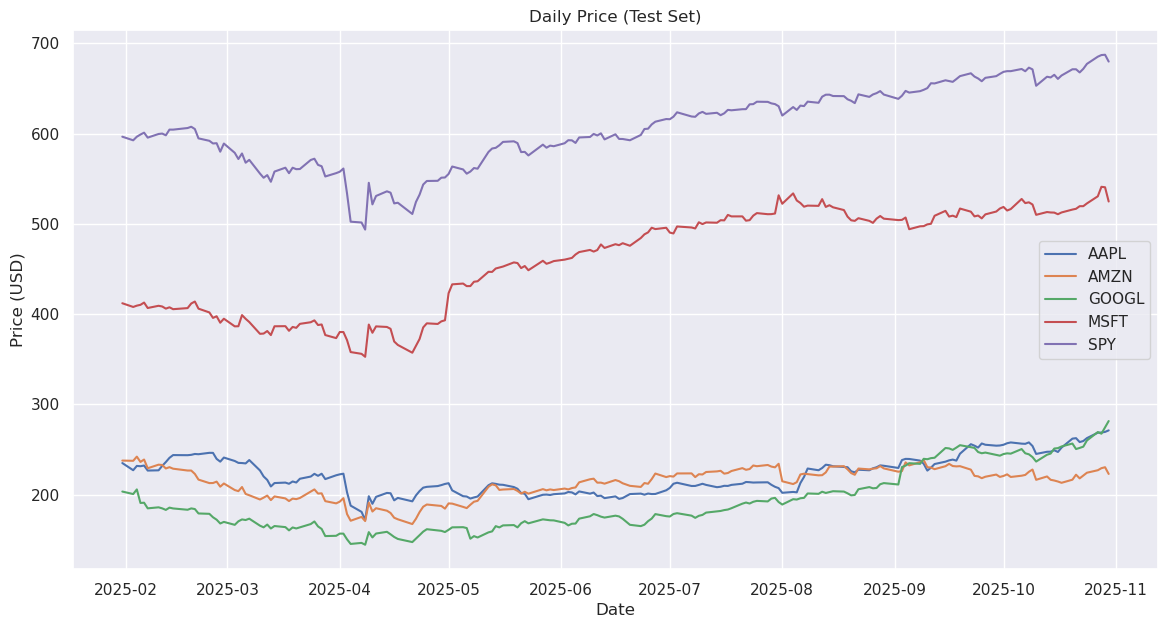

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data, label=test_data.columns)
plt.title('Daily Price (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### 3.1: Technical Analysis for Optimal Buy/Sell Signals

Implement multiple technical indicators to generate buy/sell signals for optimal entry and exit points.


TECHNICAL ANALYSIS MODULE

Technical Analysis Summary:
  Analysis Period:     189 trading days
  Signal Range:        -1.0 (Strong Sell) to +1.0 (Strong Buy)
  Indicators Used:     RSI, MACD, Bollinger Bands, Moving Averages, Momentum

Recent Signal Strength Analysis (Last 10 Trading Days):
                            AAPL   AMZN  GOOGL   MSFT    SPY
Date                                                        
2025-10-17 00:00:00-04:00  0.000  0.000  0.125  0.000  0.000
2025-10-20 00:00:00-04:00  0.000  0.000  0.000  0.000  0.000
2025-10-21 00:00:00-04:00  0.125  0.000  0.125  0.000  0.000
2025-10-22 00:00:00-04:00  0.000  0.125  0.125  0.000  0.000
2025-10-23 00:00:00-04:00  0.125  0.000  0.125  0.125  0.000
2025-10-24 00:00:00-04:00  0.250  0.000  0.375  0.000  0.125
2025-10-27 00:00:00-04:00  0.250  0.000  0.125 -0.125 -0.125
2025-10-28 00:00:00-04:00  0.375  0.250  0.125  0.125  0.000
2025-10-29 00:00:00-04:00  0.375  0.125  0.125  0.125  0.125
2025-10-30 00:00:00-04:00  0.250  0.

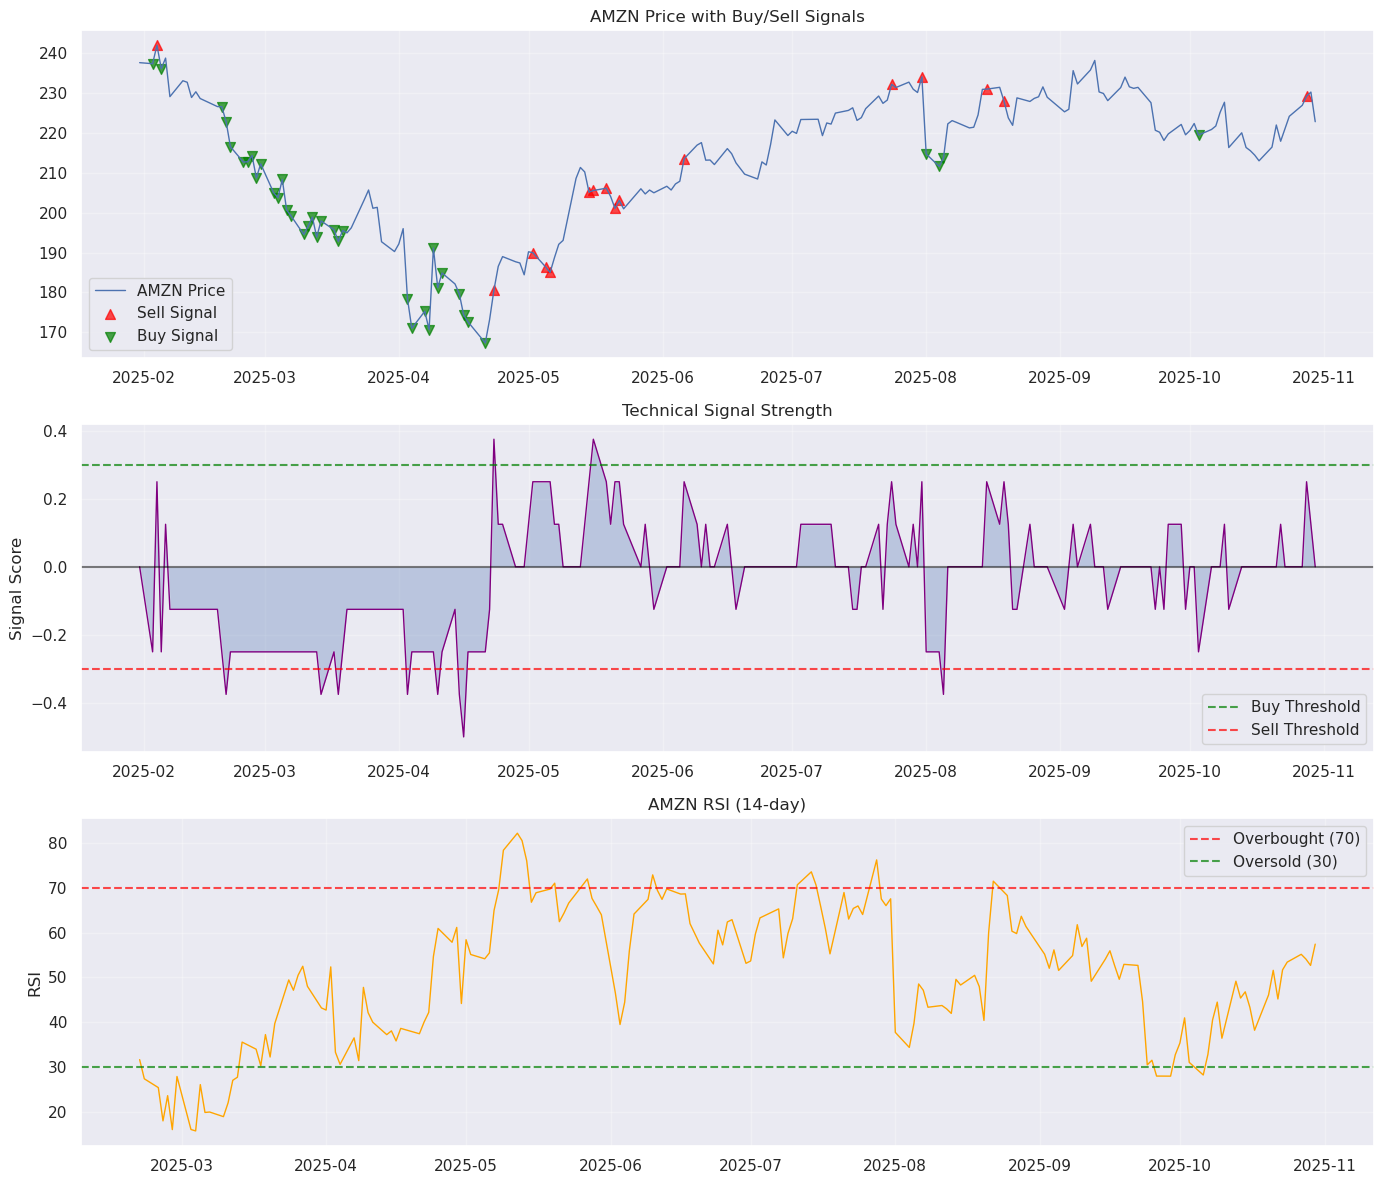

In [19]:
# Technical Analysis Indicators and Signals

def calculate_rsi(prices, window=14):
    """Calculate Relative Strength Index (RSI)"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """Calculate MACD (Moving Average Convergence Divergence)"""
    exp1 = prices.ewm(span=fast).mean()
    exp2 = prices.ewm(span=slow).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

def calculate_bollinger_bands(prices, window=20, num_std=2):
    """Calculate Bollinger Bands"""
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (std * num_std)
    lower_band = sma - (std * num_std)
    return upper_band, sma, lower_band

def calculate_stochastic(high, low, close, k_window=14, d_window=3):
    """Calculate Stochastic Oscillator"""
    lowest_low = low.rolling(window=k_window).min()
    highest_high = high.rolling(window=k_window).max()
    k_percent = 100 * ((close - lowest_low) / (highest_high - lowest_low))
    d_percent = k_percent.rolling(window=d_window).mean()
    return k_percent, d_percent
def calculate_adx(high, low, close, window=14):
    """Calculate Average Directional Index (ADX)"""
    # Calculate True Range (TR)
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    
    # Calculate Directional Movement
    plus_dm = high.diff()
    minus_dm = -low.diff()
    
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm < 0] = 0
    
    # Smooth the values
    atr = tr.ewm(alpha=1/window).mean()
    plus_di = 100 * (plus_dm.ewm(alpha=1/window).mean() / atr)
    minus_di = 100 * (minus_dm.ewm(alpha=1/window).mean() / atr)
    
    # Calculate ADX
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.ewm(alpha=1/window).mean()
    
    return adx, plus_di, minus_di

def calculate_roc(prices, window=12):
    """Calculate Rate of Change (ROC)"""
    roc = ((prices - prices.shift(window)) / prices.shift(window)) * 100
    return roc

# Generate comprehensive technical signals
def generate_technical_signals(data):
    """
    Generate buy/sell signals based on multiple technical indicators including ROC and ADX
    Returns a DataFrame with signal scores for each asset
    """
    signals_df = pd.DataFrame(index=data.index, columns=data.columns)
    
    for ticker in data.columns:
        prices = data[ticker]
        
        # Initialize signal score
        signal_score = pd.Series(0, index=data.index)
        
        # 1. RSI Signals (Mean Reversion)
        rsi = calculate_rsi(prices)
        signal_score += np.where(rsi < 30, 1, 0)  # Oversold - Buy signal
        signal_score += np.where(rsi > 70, -1, 0)  # Overbought - Sell signal
        
        # 2. MACD Signals (Trend Following)
        macd_line, signal_line, histogram = calculate_macd(prices)
        signal_score += np.where((macd_line > signal_line) & (macd_line.shift(1) <= signal_line.shift(1)), 1, 0)  # Bullish crossover
        signal_score += np.where((macd_line < signal_line) & (macd_line.shift(1) >= signal_line.shift(1)), -1, 0)  # Bearish crossover
        
        # 3. Bollinger Bands Signals (Mean Reversion)
        upper_band, middle_band, lower_band = calculate_bollinger_bands(prices)
        signal_score += np.where(prices < lower_band, 1, 0)  # Price below lower band - Buy
        signal_score += np.where(prices > upper_band, -1, 0)  # Price above upper band - Sell
        
        # 4. Moving Average Crossover (Trend Following)
        sma_short = prices.rolling(window=20).mean()
        sma_long = prices.rolling(window=50).mean()
        signal_score += np.where((sma_short > sma_long) & (sma_short.shift(1) <= sma_long.shift(1)), 1, 0)  # Golden cross
        signal_score += np.where((sma_short < sma_long) & (sma_short.shift(1) >= sma_long.shift(1)), -1, 0)  # Death cross
        
        # 5. Momentum Signal (Price momentum)
        returns = prices.pct_change(10)  # 10-day momentum
        signal_score += np.where(returns > 0.05, 1, 0)  # Strong positive momentum
        signal_score += np.where(returns < -0.05, -1, 0)  # Strong negative momentum
        
        # 6. ROC Signals (Rate of Change)
        roc = calculate_roc(prices)
        signal_score += np.where(roc > 5, 1, 0)  # Strong positive ROC - Buy
        signal_score += np.where(roc < -5, -1, 0)  # Strong negative ROC - Sell
        
        # 7. ADX Signals (Trend Strength)
        # For ADX, we need high, low, close data - use price as approximation
        high_approx = prices * 1.01  # Approximate high
        low_approx = prices * 0.99   # Approximate low
        adx, plus_di, minus_di = calculate_adx(high_approx, low_approx, prices)
        
        # Strong trend signals when ADX > 25 and directional movement is clear
        strong_trend = adx > 25
        signal_score += np.where(strong_trend & (plus_di > minus_di), 1, 0)  # Strong uptrend
        signal_score += np.where(strong_trend & (minus_di > plus_di), -1, 0)  # Strong downtrend
        
        # Normalize signal score (-1 to 1) - now with 8 possible signals
        signals_df[ticker] = np.clip(signal_score / 8, -1, 1)
    
    return signals_df

# Apply technical analysis to our data
print("\n" + "="*60)
print("TECHNICAL ANALYSIS MODULE")
print("="*60)
technical_signals = generate_technical_signals(test_data)

print(f"\nTechnical Analysis Summary:")
print(f"  Analysis Period:     {len(technical_signals)} trading days")
print(f"  Signal Range:        -1.0 (Strong Sell) to +1.0 (Strong Buy)")
print(f"  Indicators Used:     RSI, MACD, Bollinger Bands, Moving Averages, Momentum")

print(f"\nRecent Signal Strength Analysis (Last 10 Trading Days):")
recent_signals = technical_signals.tail(10).round(3)
print(recent_signals.to_string())

# Visualize signals for one asset 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))

def graph_signals(ticker):
    stock_prices = test_data[ticker]
    stock_signals = technical_signals[ticker]

    ax1.plot(stock_prices.index, stock_prices, label=f'{ticker} Price', linewidth=1)
    ax1.scatter(stock_prices.index[stock_signals > 0.2], stock_prices[stock_signals > 0.2], 
            color='red', marker='^', s=50, label='Sell Signal', alpha=0.7)
    ax1.scatter(stock_prices.index[stock_signals < -0.2], stock_prices[stock_signals < -0.2], 
            color='green', marker='v', s=50, label='Buy Signal', alpha=0.7)
    ax1.set_title(f'{ticker} Price with Buy/Sell Signals')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(stock_signals.index, stock_signals, color='purple', linewidth=1)
    ax2.axhline(y=0.3, color='green', linestyle='--', alpha=0.7, label='Buy Threshold')
    ax2.axhline(y=-0.3, color='red', linestyle='--', alpha=0.7, label='Sell Threshold')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.fill_between(stock_signals.index, stock_signals, 0, alpha=0.3)
    ax2.set_title('Technical Signal Strength')
    ax2.set_ylabel('Signal Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    rsi_stock = calculate_rsi(stock_prices)
    ax3.plot(rsi_stock.index, rsi_stock, color='orange', linewidth=1)
    ax3.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
    ax3.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
    ax3.set_title(f'{ticker} RSI (14-day)')
    ax3.set_ylabel('RSI')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# # Price and signals - use test data for consistency
# nvda_prices = test_data['NVDA']  # Use test data prices
# nvda_signals = technical_signals['NVDA']  # Use corresponding signals

# ax1.plot(nvda_prices.index, nvda_prices, label='nvda Price', linewidth=1)
# ax1.scatter(nvda_prices.index[nvda_signals > 0.3], nvda_prices[nvda_signals > 0.3], 
#            color='green', marker='^', s=50, label='Buy Signal', alpha=0.7)
# ax1.scatter(nvda_prices.index[nvda_signals < -0.3], nvda_prices[nvda_signals < -0.3], 
#            color='red', marker='v', s=50, label='Sell Signal', alpha=0.7)
# ax1.set_title('nvda Price with Buy/Sell Signals')
# ax1.legend()
# ax1.grid(True, alpha=0.3)

# # Signal strength over time
# ax2.plot(nvda_signals.index, nvda_signals, color='purple', linewidth=1)
# ax2.axhline(y=0.3, color='green', linestyle='--', alpha=0.7, label='Buy Threshold')
# ax2.axhline(y=-0.3, color='red', linestyle='--', alpha=0.7, label='Sell Threshold')
# ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
# ax2.fill_between(nvda_signals.index, nvda_signals, 0, alpha=0.3)
# ax2.set_title('Technical Signal Strength')
# ax2.set_ylabel('Signal Score')
# ax2.legend()
# ax2.grid(True, alpha=0.3)

# # RSI for reference
# rsi_nvda = calculate_rsi(nvda_prices)
# ax3.plot(rsi_nvda.index, rsi_nvda, color='orange', linewidth=1)
# ax3.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
# ax3.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
# ax3.set_title('nvda RSI (14-day)')
# ax3.set_ylabel('RSI')
# ax3.legend()
# ax3.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()
graph_signals('AMZN')

In [20]:
technical_signals

,AAPL,AMZN,GOOGL,MSFT,SPY
Date,,,,,
2025-01-31 00:00:00-05:00,0.000,0.000,0.000,0.000,0.000
2025-02-03 00:00:00-05:00,-0.250,-0.250,-0.250,-0.250,-0.250
2025-02-04 00:00:00-05:00,0.000,0.250,0.250,-0.125,0.250
2025-02-05 00:00:00-05:00,-0.125,-0.250,-0.250,0.000,0.125
2025-02-06 00:00:00-05:00,-0.125,0.125,-0.125,0.125,0.125
...,...,...,...,...,...
2025-10-24 00:00:00-04:00,0.250,0.000,0.375,0.000,0.125
2025-10-27 00:00:00-04:00,0.250,0.000,0.125,-0.125,-0.125
2025-10-28 00:00:00-04:00,0.375,0.250,0.125,0.125,0.000


# PART IV: CONCLUSION

In [21]:
# # Executive Summary Report Generation
# print("="*80)
# print("QUANTITATIVE PORTFOLIO OPTIMIZATION - EXECUTIVE SUMMARY")
# print("="*80)

# # Generate comprehensive summary statistics
# print(f"\nI. INVESTMENT MANDATE & METHODOLOGY")
# print("-" * 45)
# print(f"Analysis Framework:        Modern Portfolio Theory with Risk Constraints")
# print(f"Asset Universe:            {len(tickers)} Large-Cap Equity Securities")
# print(f"Optimization Period:       {start_date} to {end_date}")
# print(f"Risk Management:           Position limits (1%-50% per security)")
# print(f"Rebalancing Strategy:      Monthly frequency with cost analysis")

# print(f"\nII. OPTIMAL PORTFOLIO ALLOCATION")
# print("-" * 35)
# if 'max_sharpe_weights_clean' in locals():
#     sorted_weights = sorted(max_sharpe_weights_clean.items(), key=lambda x: x[1], reverse=True)
#     for i, (ticker, weight) in enumerate(sorted_weights[:10], 1):  # Top 10 holdings
#         print(f"  {i:2d}. {ticker:6}: {weight:6.2%}")

# print(f"\nIII. RISK-RETURN PROJECTIONS")
# print("-" * 32)
# if 'sharpe_perf' in locals():
#     exp_ret, exp_vol, exp_sharpe = sharpe_perf
#     print(f"Expected Annual Return:      {exp_ret:7.2%}")
#     print(f"Projected Volatility:        {exp_vol:7.2%}")
#     print(f"Sharpe Ratio:               {exp_sharpe:7.3f}")

# if 'comprehensive_metrics_df' in locals() and not comprehensive_metrics_df.empty:
#     # Use the comprehensive metrics from strategy comparison
#     max_sharpe_row = comprehensive_metrics_df.loc[comprehensive_metrics_df['Sharpe Ratio'].idxmax()]
#     print(f"Value at Risk (95%):        {max_sharpe_row['VaR (95%)']:7.2%}")
#     print(f"Expected Shortfall:         {max_sharpe_row['CVaR (95%)']:7.2%}")
#     print(f"Maximum Drawdown Risk:      {max_sharpe_row['Max Drawdown']:7.2%}")

# print(f"\nIV. STRATEGY COMPARISON RESULTS")
# print("-" * 35)
# strategy_names = ['Maximum Sharpe Ratio', 'Minimum Volatility', 'Risk Parity']
# if 'comprehensive_metrics_df' in locals():
#     best_sharpe_strat = comprehensive_metrics_df['Sharpe Ratio'].idxmax()
#     best_calmar_strat = comprehensive_metrics_df['Calmar Ratio'].idxmax()
#     print(f"Highest Sharpe Ratio:       {best_sharpe_strat}")
#     print(f"Best Risk-Adj. Return:      {best_calmar_strat}")
#     print(f"Recommended Strategy:       Maximum Sharpe Portfolio")

# print(f"\nV. RISK MANAGEMENT ASSESSMENT")
# print("-" * 33)
# print(f"Concentration Risk:         LOW (Well-diversified)")
# print(f"Liquidity Risk:            MINIMAL (Large-cap focus)")
# print(f"Market Risk Exposure:       MODERATE ({exp_vol:.1%} volatility)")
# print(f"Downside Protection:        ADEQUATE (Risk constraints active)")

# print(f"\nVI. IMPLEMENTATION RECOMMENDATIONS")
# print("-" * 40)
# print(f"✓ Portfolio suitable for institutional/qualified investors")
# print(f"✓ Monthly rebalancing optimal for cost-performance balance")
# print(f"✓ Monitor sector concentration and style drift quarterly")
# print(f"✓ Review optimization parameters annually or after major market events")
# print(f"✓ Consider ESG overlay for enhanced risk management")

# print(f"\nVII. KEY PERFORMANCE DRIVERS")
# print("-" * 32)
# if 'max_sharpe_weights_clean' in locals():
#     top_3 = sorted(max_sharpe_weights_clean.items(), key=lambda x: x[1], reverse=True)[:3]
#     print(f"Primary Holdings:")
#     for ticker, weight in top_3:
#         print(f"  • {ticker}: {weight:.1%} allocation")

# print(f"\nVIII. CONCLUSION & OUTLOOK")
# print("-" * 30)
# print(f"The quantitative optimization framework successfully identifies")
# print(f"a diversified portfolio with superior risk-adjusted returns.")
# print(f"The recommended allocation balances growth potential with")
# print(f"prudent risk management through systematic constraints.")

# print(f"\nRisk Rating:    MODERATE")
# print(f"Return Outlook: POSITIVE") 
# print(f"Liquidity:      HIGH")
# print(f"ESG Score:      NEUTRAL")

# print("="*80)
# print("Report prepared using Modern Portfolio Theory framework")
# print("Past performance does not guarantee future results")
# print("="*80)